# Housing Price Dataset : Regression 


Download and extract the Housing Price Dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background']) #


import os
import tarfile
from six.moves import urllib
import warnings
warnings.filterwarnings('ignore')

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
WORKING__PATH = os.getcwd()
HOUSING_PATH = os.path.join(WORKING__PATH, "dataset")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# a function is useful if the dataset could be updated in the future
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    '''
    downloads housing price dataset from url and extracts it in the desired directory
    '''
    # if the desired directory does not exist, it is created
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    # dowloads from the url to the desired path
    urllib.request.urlretrieve(housing_url, tgz_path)
    # open and extracts the file
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    # closes the file
    housing_tgz.close()
    
fetch_housing_data()

Load dataset (csv file) using pandas

In [2]:
import pandas as pd
def load_housing_data(housing_path = HOUSING_PATH):
    '''
    loads the housing price dataset csv into a pandas dataframe
    '''
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# load the data
housing = load_housing_data()
# look at the data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Let's get some more exploratory statistics on the dataset

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We have 10 total columns, 9 feature variables and 1 target variable.

We don't have missing values in our dataset except for a few in the total_bedrooms variable.

All variables are numeric except ocean_proximity which is an object.

Since we loaded our data from a csv file we know it must be a text attribute (and we can see it from the head call on the dataframe).

It is probably a categorical variable (the first 5 rows had all the same value for it), let's check the categories and counts using the value_counts() method.


In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let's look at the numeric variables using the describe() method:

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Let's check the distributions of our variables 

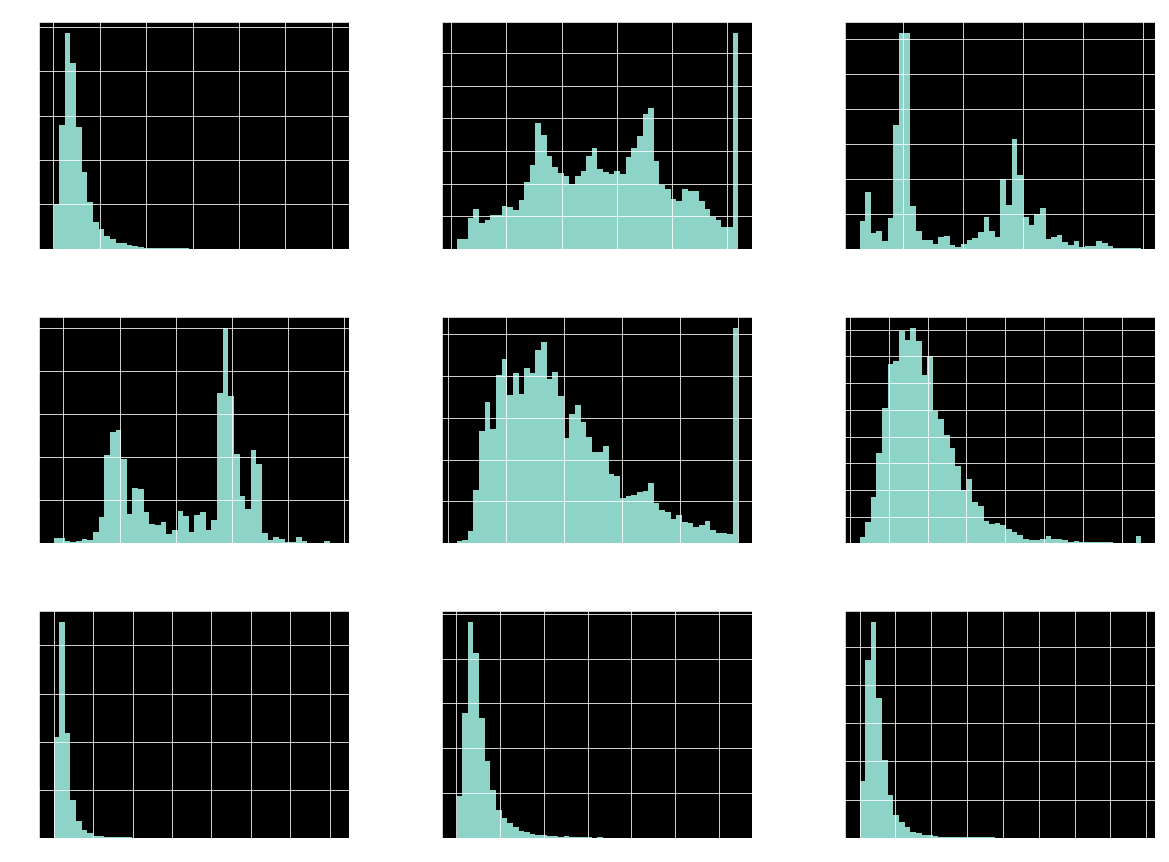

In [6]:
housing.hist(bins=50, figsize=(20,15)) 
plt.show()

Observations:
+ housing_median_age and median_house_value are capped (there is an extreme amount of counts on the max level)
+ median_income also capped and it is not in dollars, inquire about it's nature: it is in 10k dollars
+ most distributions are left skewed and have long tails, we will have to do something to make them more bell shaped
+ attributes have very different scales


Create test set: take a **random sample** of 20% of the whole dataset
If the dataset was large (this one is small) we could take a lower fraction of it as test set.
We set a random seed for reproducibility:

In [7]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


Random sampling is generally enough if our sample is large(esp. compared to the number of features).

If it's not large enough there's a risk of introducing significant sample bias.

To counteract this, we should choose our sample in a way it represents the total population using **stratification**.

For example, we suppose we talked with an expert on house pricing, and he told us that the **median income** is very important to predict **median housing price**. We may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since this variable is continuous we need to create an **income categorical variable**.

We need to have a sufficient amount of instances in our dataset for each stratum, or else the estimate of the stratum's importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.

We will use the pandas.cut function for this. From the pandas documentation:

    Use cut when you need to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins.

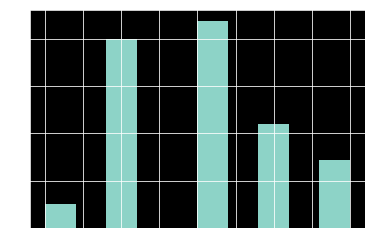

In [8]:
import numpy as np
# create a categorical variable from median_income; 5 bins 
housing["income_cat"] = pd.cut(housing["median_income"], 
                       bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                       labels = [1, 2, 3, 4, 5])
housing["income_cat"].hist(normed = True)



We can now perform a stratified sampling based on the income categorical variable.

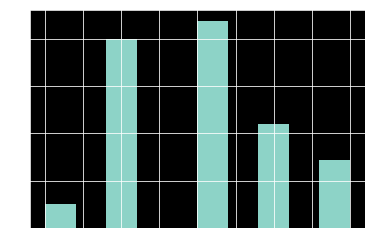

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].hist(normed = True)

We can see that our test set has similar frequencies for our strata compared to the whole dataset. 

Let's check the frequencies in our random test set.

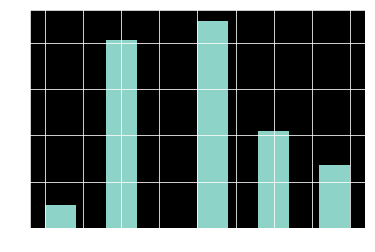

In [10]:
test_set["income_cat"] = pd.cut(test_set["median_income"], 
                       bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                       labels = [1, 2, 3, 4, 5])
test_set["income_cat"].hist(normed = True)

In [11]:
t = housing["income_cat"].value_counts() / len(housing["income_cat"])
r = test_set["income_cat"].value_counts() / len(test_set["income_cat"])
s = strat_test_set["income_cat"].value_counts() / len(strat_test_set["income_cat"])
random_vs_strat = pd.DataFrame( {"total" : t, "random" : r, "stratified" : s, "total_vs_random %" : (t - r)*100, "total_vs_stratified %" : (t - s) * 100})
print(random_vs_strat)

      total    random  stratified  total_vs_random %  total_vs_stratified %
3  0.350581  0.358527    0.350533          -0.794574               0.004845
2  0.318847  0.324370    0.318798          -0.552326               0.004845
4  0.176308  0.167393    0.176357           0.891473              -0.004845
5  0.114438  0.109496    0.114583           0.494186              -0.014535
1  0.039826  0.040213    0.039729          -0.038760               0.009690


In [12]:
for set_ in(strat_train_set, strat_test_set, test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

# Data visualization

Put the test set aside and explore only the training set. If the training set is very large it makes sense to sample a smaller exploration set. In our case the set is quite small so we can work directly on the full set. Let's create a copy so we can play with it w/o harming the training set:

In [13]:
housing = strat_train_set.copy() # note that this is a pandas.DataFrame method --> by default it's a Deep Copy (pass by value)

## Visualizing Geographical Data

Since there's geo information(lat & long), it is a good idea to create a scatterplot of all districts to visualize the data:

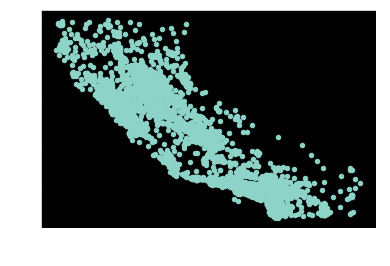

In [14]:
housing.plot(kind = "scatter", x= "longitude", y = "latitude")

It's hard to see any particular pattern. Setting the alpha to 0.1 makes it much easier to visualize the places where there is a high density of data points(it counteracts overplotting):

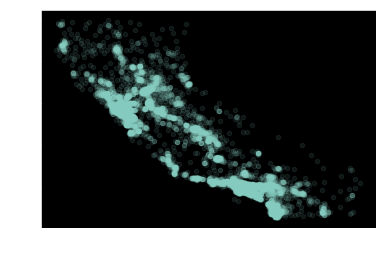

In [15]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

We can now clearly see the high-density areas: the Bay Area and around LA and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

Now let's add the housing prices. The radius of each circle represents the district's population (option s, size), and the color represents the price (option c, color). 

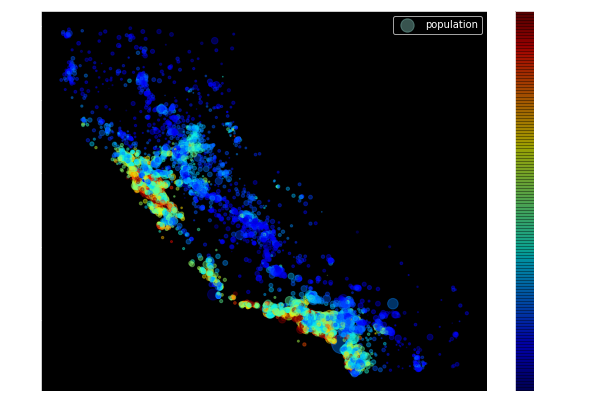

In [16]:
housing.plot(kind = "scatter", x= "longitude", y = "latitude", alpha = 0.4,
            s = housing["population"]/100, label = "population", figsize = (10, 7),
            c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)

plt.legend()

This visualization tells us that the housing prices are very much related to the location(e.g. close to the ocean) and to the pop. density, as we could already expect.

It will be probably useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in NorCal the housing prices in coastal districts are not too high, so it's not a simple rule.

## Looking for Correlations

Since the dataset is not too large, we can easily compute the standard correlation coefficient (Pearson's r) between every pair of attributes using the corr() method.

Since our target is the median house price, let's look which variables have a high correlation with it:

In [17]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Corr values can go from -1 to +1 and indicate whether there is a linear correlation between two variables and the sign of that relation.

we can see that the median_house_value is most positively correlated with the median_income. There is a weak negative correlation with the latitude: the more we go North the lower the prices.


Another way to check for correlation between attributes is to plot:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000156765B5198>,
      dtype=object)

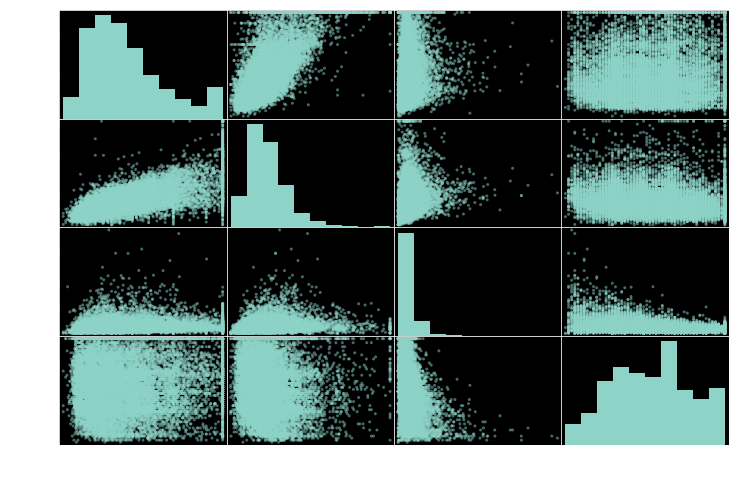

In [18]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))

The most promising attribute to predict the median house value is the median 
income(it's the only one showing some linear correlation).

It's also nice to notice that there doesn't seem to be collinearity between our predictors.

Let's zoom on their correlation scatterplot:

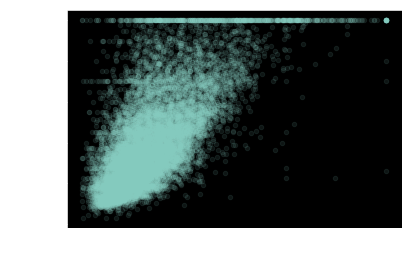

In [19]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

We can clearly see a trend here and the capping at 500k of the median_house_value is more evident.

But we can see other less obvious straight lines at 450k and 350k.

We may want to remove the corresponding observations to prevent our algorithm from learning to reproduce these data quirks.

# Data wrangling

## Experimenting with Attribute Combinations

We may want to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don't know how many households there are. We really want the # of rooms per household.

Similarly, the tot # of bedrooms by itself is not very useful, we want to compare it to the # of rooms. Population per household also seems like an interesting attribute combination to look at.

Let's create these new attributes and look at the correlation matrix again:

In [20]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new bedrooms_per_room is much more correlated w/ the median house value than the total number of rooms or bedrooms. Apparently, houses with a lower bedroom/room ratio tend to be more expensive.

The # of rooms per household is also more informative than the total number of rooms in a district -- obviously, the larger the houses, the more expensive they are.

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. This is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

## Prepare the Data for Machine Learning Algorithms

It's time to prepare the data for your Machine Learning algorithms. Instead of just doing it manually, you should write functions to do that, for several good reasons:

+ This will allow you to reproduce these transformations easily on any dataset (formatted in the same way)
+ You will gradually build a library of transformation functions that you can reuse in future projects
+ you can use these functions in your live system to transform new data before feeding it to your algorithms
+ This will make it possible for you to easily test various transformations and see which combinations of transformations work best

Let's first revert to a clean training set( by copying strat_train_set once again), and let's separate predictors and the labels since we don't necessarily want to apply the same transformations to the predictors and the target values

**note**

drop() creates a copy of the data in housing and does not affect strat_train_set):

In [21]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

Most ML algos cannot work with missing features, so let's create a few functions to take care of them. We noticed earlier that the total_bedrooms attribute has some missing values, so let's fix this.

We have three options to deal with missing values:

+ Get rid of the corresponding observations(in this case districts)
+ Get rid of the whole feature
+ Set the values to some value(zero, the mean, the median)

We can accomplish these easily using DataFrame's dropna(), drop(), and fillna() methods:

In [22]:
housing.dropna(subset = ["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis = 1) # option 2
median = housing["total_bedrooms"].median() #option 3
housing["total_bedrooms"].fillna(median, inplace = True)

If you choose option 3, you should compute the median value on the **training** set, and use it to fill the missing values in the training set, but also don't forget to save the median value that you have computed. 

We will need it later to replace missing values in the **test** set when we will evaluate our system and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: SimpleImputer.

First we need to create a SimpleImputer instance, specifying that we want to replace each attribute's missing values with the median of that attribute

In [23]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")
"""
since the median can only be computed on numerical attributes, we need to 
create a copy of the data without the text attribute ocean_proximity column
"""
housing_num = housing.drop("ocean_proximity", axis = 1)
"""
now we can fit the imputer instance to the training data using the fit() 
method
"""
imputer.fit(housing_num)
imputer.statistics_

"""
The imputer has simply computed the median of each attribute and stored the
result in its statistics_ instance variable. Only the total_bedrooms
attribute had missing values, but we cannot be sure that there won't be
any missing values in new data after the system goes live

"""
X = imputer.transform(housing_num)
"""
The result is a plain NumPy array containing the transformed features. 
If you want to put it back into a Pandas DF it's simple:
"""
housing_tr = pd.DataFrame(X, columns = housing_num.columns)


## Handling Text and Categorical Attributes

We left out the categorical attribute ocean_proximity because it is a text attribute so we cannot compute its median.

Most ML algos prefer to work with numbers anyway, so we should convert these categories from text to numbers.
We can use the OrdinalEncoder class:

In [24]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)


from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])
"""
We still can access the list of categories using the categories_ instance 
variable. 
"""
print(ordinal_encoder.categories_)

[[0.]
 [0.]
 [4.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


One issue with this representation is that ML algorithms will assume that
two nearby values are more similar than two distant values. This may be fine
if our categories are ordered (e.g.: "bad, "average", "good") but it's 
obviously not the case for the ocean_proximity column 
(e.g. category 0 and 4 are clearly more similar than categories 0 and 1 
-- in reality we don't care to order these cats in this case).

To fix this issue, a common solution is to create one binary attribute, like
an indicator, for each category: one attribute equal to 1 when the category 
is "<1H OCEAN" (and 0 otherwise) etc.

This is called *one-hot* encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called *dummy* attributes. Scikit-Learn provides a OneHotEncoder
class to convert categorical values into one-hot vectors:

In [25]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy *sparse matrix* instead of a NumPy array.
This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding we would get a matrix w/ thousands of columns, and the matrix will be full of zeros except for a single 1 per row.
Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the non-zero elements.

We can use it mostly like a normal 2D array, but if you really want to convert it to a (dense) NumPy array, just call the  toarray() method.

Once again we can access the list of categories using the encoder's categories_ instance variable.

In [26]:
housing_cat_1hot.toarray()
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

If a categorical attribute has a large number of possible categories, then one-hot encoding will result in a large number of input features.
This may slow down training and degrade performance. If this happens, we may want to replace the categorical input with useful numerical features related to the categories: for example, we could replace the ocean_proximity feature with the distance to the ocean(similarly, a country code could be replaced with the country's population and GDP per capita).

Alternatively, we could replace each category with a learnable low dimensional vector calld an *embedding*. Each category's representation would be learned during training: this is an example of *representation learning*.

## Custom Transformers

Sometimes we wil need to write our own transformers for tasks such as custom cleanup operations or combining specific attributes. We will want our transformers to work seamlessly with Scikit-Learn functionalities(such as pipelines), and since Scikit-Learn relies on duck typing(not inheritance), all we need it is to create a class and implement three methods:
+ fit() (returning self)
+ transform()
+ fit_transform()

We can get fit_transform() one for free by simply adding TransformerMixin as a base class. 

Also, if we add BaseEstimator as a base class (and avoid * args and ** kargs in our constructor) we will get two extra methods(get_params() and set_params()) that will be useful for automatic hyperparameter tuning. For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

"""
hardcoded indexes for the attributes we need to compute the composite attributes we want to add
"""
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self # nothing else to do
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room] # np.c_ is like cbind
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values) #housing.values is a np matrix

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default(it is often helpful to provide sensible defaults). This hyperparameter will allow us to easily find out whether adding this attribute helps the ML algo or not. More generally, we can add a hp to gate any data preparation step that we are not 100% sure about.

The more we automate these data prep steps, the more combinations we can automatically try out, making it much more likely that we will find a great combination(and this will save us a lot of time).

## Feature Scaling

One of the most important transformations we need to apply to our data is *feature scaling*. With few exceptions, ML algos don't perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. 

Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale:
+ min-max scaling
+ standardization

Min-max scaling (aka *normalization*) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by substracting the min value and dividing by the max minus the min.


Scikit-Learn provides a transformed MinMaxScaler for this.
It has a feature_range hyperparameter that lets you change the range if we don't want 0-1 for some reason.


Standardization is quite different: first it substracts the mean value, and then it divdies by the sandard deviation so that the resulting distribution has unit v
ariance.

Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g. neural networks often expect an input value ranging from 0 to 1).
However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100(by mistake). Min-max scaling would then crush all the other values from 0-15 down to 0-0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization.

**warning**

As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset(including the test set).
Only then we can use them to transform the training set and the test set(and the new data).

## Transformation Pipelines

There are many transformation steps that need to be executed in the right order. Fortunately Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes.

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
print(type(housing_num_tr))

<class 'numpy.ndarray'>


The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a StandardScaler, which is a transformer, so the pipeline has a transform() method that applies all the transforms to the data in sequence(and of course also a fit_transform() method, which is the one we used).

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.
Scikit-Learn has the ColumnTransformer class for this purpose, and it works great with Pandas DataFrames.

Let's use it to apply all the transformations to the housing data:

In [29]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

"""
ColumnTransformer requires a list of tuples as input,
where each tuple contains a name, a transformer, and a list of names or indices
of columns that the transformer should be applied to.
"""

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

Note that OneHotEncoder returns a sparse matrix, while the num_pipeline
returns a dense matrix. When there is such a mix of sparse and dense matrices,
the ColumnTransformer estimates the density of the final matrix(i.e. the ratio
of non-zero cells), and it returns a sparse matrix if the density is lower
than a given threshold (by default, sparse_threshold = 0.3).
In this example, it returns a dense matrix.
We have a preprocessing pipeline that takes the full housing data and applies
the appropriate transformations to each column

**note**
Instead of a transformer, we can specify the string "drop" if you want the columns to be dropped. Or we can specify "passthrough" if we want the columns to be left untouched. By default, the remaining columns (i.e. the ones thet were not listed) will be dropped, but we can set the remainder hyperparameter to any transformer(or to "passthrough") if we want these columns to be handled differently.

# Select and Train a model

We:
+ framed the problem
+ got the data and explored it
+ sampled a training set and test set
+ wrote transformation pipelines to clean up and prepare our data for ML automatically

We are now ready to select and train a ML model.

## Training and Evaluating on the Training Set

Let's first train a Linear Regression model:

In [30]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

"""
Let's try it out on a few instances from the training set
"""
# get predictors
some_data = housing.iloc[:5]
# get real response
some_labels = housing_labels.iloc[:5]
# transform data
some_data_prepared = full_pipeline.transform(some_data)
# predictions
print("Predictions:", lin_reg.predict(some_data_prepared))
# true values
print("Labels:", list(some_labels))



Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works although the predictions are not exactly accurate.


Let's measure this regression model's RMSE on the whole training set using Scikit-Learn's mean_squared_error function:

In [31]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.19819848923


Better than nothing but clearly not a great score: most districts' median_housing_values range between \\$120k and \\$265k, so a typical prediction error of \\$68k is not very satisfying.

This is an example of a model **underfitting** the training data.
When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. 

The main ways to fix underfitting are:

+ select a more powerful model
+ feed the algo with better features
+ reduce the constraints on the model

This model is not *regularized*, so this rules out the last option.
We could try to add more features(e.g. the log of the population), but first let's try a more comple model to see how it does.


Let's train a DecisionTreeRegressor. This is a **powerful** model capable of finding complex nonlinear relationships in the data:

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

"""
Let's evaluate it on the training set
"""

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)




0.0


This model evidently has **badly** overfit the data. Let's get a better evaluation using Cross-Validation

## Better Evaluation Using Cross-Validation


One way to evaluate the Decision Tree model would be to use the Train_test_split function to split the training set into a smaller training set and a validation set, then train our models against the smaller training set and evaluate them against the validation set. 

A great alternative is to use Scikit-Learn's K-fold cross-validation feature.

The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The results is an array containing the 10 evaluation scores

**warning**

Scikit-Learn's cross-validation features expect a utility function(greater is better) rather than a cost function(lower is better), so the scoring function is actually the opposite of the MSE(i.e. a negative value), which is why the following code computes -scores before calculating the square root.

In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

"""
small function to display the scores
"""

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69527.96349781 68432.59828322 70664.88662418 69106.30578764
 71279.90223613 74702.98621316 70846.12163253 71320.39989367
 77448.87466244 70117.43225677]
Mean: 71344.74710875588
Standard deviation: 2599.077011699862


Now the Decision Tree doesn't look as good as it did earlier, in fact it seems to perform worse than the Linear Regression model.

Notice that cross-validation allows you to get not only an estimate of the performance of the model, but also a measure of how precise this estimate is(i.e. its standard deviation). The Decision Tree has a score of approximately 71k plus/minus 2.439k. We would not have this information if we just used one validation set.


Cross-validation comes at the **cost of training the model several times**, so it is not always possible.

In [34]:
"""
Let's compute the same scores for the Linear Regression model just to be sure
"""

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798349


That's right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Let's try one last model now: the RandomForestRegressor. It works by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called *Ensemble Learning*, and it is often a great way to push ML algorithms even further.

In [35]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(forest_predictions, housing_labels))
print(forest_rmse)


forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring = "neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

22293.64021345773
Scores: [51841.22342145 49878.44502277 52085.73915428 54500.78918818
 52643.05981083 56150.73090475 51533.12333658 50742.55894547
 55555.68354481 51956.57773301]
Mean: 52688.79310621459
Standard deviation: 1952.6684206608709


Random Forest looks very promising.

However, note that the score on whole the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. 

Possible solutions for overfitting are:

+ simplify the model
+ constrain it(regularization)
+ get a lot more training data

**note**

We shoud save every model we experiment with, so we can come back easily to any model we want.

We should make sure to save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well.

This will allow us to easily compare scores across model types, and compare the types of errors they make. We can easily save Scikit-Learn models by using Python's pickle module, or using sklearn.externals.joblib, which is more efficient at serializing large NumPy arrays:

In [36]:
from sklearn.externals import joblib

# if statement to not run the following example code:
if False:
    # to save
    joblib.dump(my_model, "my_model.pkl")
    # to load
    my_model_loaded = joblib.load("my_model.pkl")

## Fine-Tune Our Model

Let's assume that we now have a shortlist of promising models. We now need to fine-tune them. Let's look at a few ways we can do that:

### Grid Search

One way to do that would be to try manually different hyperparameters until we find a great combination of hyperparamter values -> long and tedious, may not have time to explore many combinations 

Instead we should get Scikit-Learn's GridSearchCV to search the hyperparameter space for us. All we need to do is tell it which hyperparameters we want to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [37]:
from sklearn.model_selection import GridSearchCV

"""
The defined parameter grid below will tell Scikit-Learn to first
evaluate all 3x4 = 12 combinations of n_estimators and max_features
specified in the first dictionary, then try all 2 x 3 = 6 combos
specified in the second dict, but this time with the bootstrap
hyperparameter set to False instead of True(which is the default
value for this hyperparameter).
"""

param_grid = [
    {"n_estimators" : [3, 10, 30], "max_features" : [2, 4, 6, 8]},
    {"bootstrap" : [False], "n_estimators" : [3,10], "max_features" : [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                          scoring = "neg_mean_squared_error",
                          return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

**note**

When we do not have a clue about what value a hyperparameter should have, a simple approach is to try out consecutive power of 10 (or a smaller number if we want a more fine-grained search, as shown in the above example with the n_estimators hyperparameters).


All in all the grid search will explore 12 + 6 - 18 combinations of RandomForestRegressor hyperparameter values, and it will train each model five times(we set 5 as the fold of our cross validation).

All in all there will be 18 x 5 = 90 rounds of training. It may take quite a long time, but when it is done we can get the best combinations of parameters like this:

In [38]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

**note**

Since 30 is the max value for n_estimators that was evaluated, we should probably try searching again with higher values, since the score may continue to improve


We can also get the best estimator directly:

In [39]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

**note**

If GridSearchCV is initialized with refit = True (which is the default), then once it finds the best estimator using cross-validation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its performance.

And of course the evaluation scores are also available:

In [40]:
cvres = grid_search.cv_results_

In [41]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65504.67906464017 {'max_features': 2, 'n_estimators': 3}
55679.24156585893 {'max_features': 2, 'n_estimators': 10}
52710.23794352378 {'max_features': 2, 'n_estimators': 30}
60385.174400283984 {'max_features': 4, 'n_estimators': 3}
52872.950873003574 {'max_features': 4, 'n_estimators': 10}
50434.558426093965 {'max_features': 4, 'n_estimators': 30}
58650.20819539034 {'max_features': 6, 'n_estimators': 3}
51963.90798720087 {'max_features': 6, 'n_estimators': 10}
50160.62257569208 {'max_features': 6, 'n_estimators': 30}
58727.16677923899 {'max_features': 8, 'n_estimators': 3}
51796.76961603432 {'max_features': 8, 'n_estimators': 10}
49920.78219425433 {'max_features': 8, 'n_estimators': 30}
63014.072192888634 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54336.06536332143 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60893.298759424804 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53265.34218023622 {'bootstrap': False, 'max_features': 3, 'n_estimators

In this example we obtain the best result with the max_features hyperparameter set to 6(8 is pretty close) and the n_estimators hyperparameter to 30.


The RMSE score for this combination is 49,896 which is slightly better than the score we got earlier using the default hyperparameter values.

**note**


We can treat some of the data preparation steps as hyperparameters. For example, the grid search will automatically find out whether or not to add a feature we were not sure about(e.g. using the add_bedrooms_per_room hyperparameter of our CombinedAttributesAdder transformer). It may similarly be used to automatically find the best way to handle outliers, missing features, feature selection, and more.

### Randomized Search

The grid search approach is fine when we are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

+ If we let the randomized search run for, say 1000 iterations, this approach will explore 1000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).
+ We have more control over the computing budget we want to allocate to hyperparameter search, simply by setting the number of iterations.

### Ensemble Methods

Another way to fine-tune our system is to try to combine the models that perform best. The group (or "esemble") will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different type of errors.

### Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForest can indicate the relative importance of each attribute for making accurate predictions.

It is a kind of **feature** selection

In [42]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([7.01220939e-02, 6.07875212e-02, 4.44493512e-02, 1.58549480e-02,
       1.51946664e-02, 1.62409187e-02, 1.48429658e-02, 3.96977573e-01,
       3.58815686e-02, 1.08880810e-01, 5.35044042e-02, 9.45962204e-03,
       1.52647209e-01, 2.41425064e-05, 1.80338242e-03, 3.32882299e-03])

In [43]:
"""
Let's display these importance scores next to
their corresponding attribute names:
"""
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse = True)


[(0.39697757267517436, 'median_income'),
 (0.1526472094960761, 'INLAND'),
 (0.10888080993992473, 'pop_per_hhold'),
 (0.07012209389517476, 'longitude'),
 (0.060787521248076515, 'latitude'),
 (0.05350440421242016, 'bedrooms_per_room'),
 (0.04444935119792179, 'housing_median_age'),
 (0.03588156858396919, 'rooms_per_hhold'),
 (0.01624091869168358, 'population'),
 (0.01585494798486096, 'total_rooms'),
 (0.015194666359306866, 'total_bedrooms'),
 (0.014842965755660608, 'households'),
 (0.009459622043041049, '<1H OCEAN'),
 (0.0033288229853499223, 'NEAR OCEAN'),
 (0.0018033824249851576, 'NEAR BAY'),
 (2.4142506374258822e-05, 'ISLAND')]

With this information, we may want to try dropping some of the less useful features (e.g. apparently, only one ocean_proximity category is really useful, so we could try dropping the others).

We should also look at the specific errors that our system makes, then try to understand why it makes them and what could fix the problem (adding extra features, or on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.)

### Evaluate Our System on the Test Set

After tweaking our model for a while, we eventually have a system that performs sufficiently well. Now it's the time to evaluate the final model on the **test set**.

We just get the predictors and the labels from our test set, run our full_pipeline to transform the data (call transform(), not fit_transform(), we do not want to fit the test set), and evaluate the final model on the test set:

In [44]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47929.9926838046

In some cases, such a point estimate of the generalization error will not be quite enough to convince us to launch: what if it is just 0.1% better than the model currently in production?

We might want to have an idea of how precise this estimate is.

For this, we can compute a 95% confidence interval for the generalization error using scipy.stats.t.interval():

In [45]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                        loc = squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

array([45948.60978222, 49832.65652582])

The performance will usually be slightly worse than what we measured using cross-validation if we did a lot of hyperparameter tuning (because our system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets).

It is not the case in this example, but when it happens we must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

Now comes the project prelaunch phase: we need to present our solution (highlighting what we have learned, what worked and what did not, what assumptions were made, and what our system's limitations are), document everything and create nice presentations with clear visualizations and easy-to-remember statements (e.g. "the  median income is the number one predictor of housing prices"). In this California housing example, the final performance of the system is not better than the experts', but it may still be a good idea to launch it, especially if this frees up some time for the experts so they can work on more interesting and productive tasks.


### Launch, Monitor, and Maintain Our System

We need to get our solution ready for production, in particular by plugging the production input data sources into our system and writing tests.

We also need to write monitoring code to check our system's live performance at regular intervals and trigger alerts when it drops. This is important to catch not only sudden breakage, but also performance degradation. This is quite common because models tend to "rot" as data evolves over time, unless the models are regularly trained on fresh data.

Evaluating our system's performance will require sampling the system's predictions and evaluating them. This will generally require a human analysis. These analysts may be field experts, or workers on a crowdsourcing platform (such as Amazon Mechanical Turk or CrowdFlower). Either way, we need to plug the human evaluation pipeline into our system.

We should also make sure we evaluate the system's input data quality. Sometimes performance will degrade slightly because of a poor quality signal (e.g. a malfunctioning sensor sending random values, or another team's output becoming stale), but it may take a while before our system's performance degrades enough to trigger an alert. Ife we monitor our system's inputs, we may catch this earlier. Monitoring the inputs is particularly important for online learning systems.

Finally, we will generally want to train our models on a regular basis using fresh data. We should automate this process as much as possible, if we don't we are very likely to refresh our model only every six months (at best), and our system's performance may fluctuate severely over time. If our system is an online learning system, we should make sure we save snapshots of its state at regular intervals so we can easily roll back to a previously working state.

# Exercises
p. 85

1. try a SVM regressor, w/ various hyperparams such as kernel="linear" and various values for c; or kernel = "rbf" w/ various values for c and gamma

2. Try replacing GridSearchCV w/ RandomizedSearchCV
3. Try adding a transformer in the preparation pipeline to select only the most important attributes
4. Try creating a single pipeline that does the full data preparation plus the final prediction
5. Automatically explore some preparation options using GridSearchCV

## SVM regressor
### linear Kernel

In [46]:
#1 SVM regressor -- linear 
from sklearn.svm import SVR
#param_grid = [{"C": [1e0, 1e1], "gamma" : list(np.logspace(-2, 2)), "kernel":["rbf","linear"]}]
param_grid_linear = [{"C": [1e0, 1e1, 1e2]}]
svm_reg_linear = SVR(kernel = "linear")
#%time svm_reg.fit(housing_prepared, housing_labels)
grid_search_linear = GridSearchCV(svm_reg_linear, param_grid_linear, cv = 5, scoring = "neg_mean_squared_error", return_train_score = True)
%time grid_search_linear.fit(housing_prepared, housing_labels) # ~2 minutes w/ i74xx

'\n#1 SVM regressor -- linear \nfrom sklearn.svm import SVR\n#param_grid = [{"C": [1e0, 1e1], "gamma" : list(np.logspace(-2, 2)), "kernel":["rbf","linear"]}]\nparam_grid_linear = [{"C": [1e0, 1e1, 1e2]}]\nsvm_reg_linear = SVR(kernel = "linear")\n#%time svm_reg.fit(housing_prepared, housing_labels)\ngrid_search_linear = GridSearchCV(svm_reg_linear, param_grid_linear, cv = 5, scoring = "neg_mean_squared_error", return_train_score = True)\n%time grid_search_linear.fit(housing_prepared, housing_labels) # ~2 minutes w/ i74xx\n'

I created a class for wrapping all procedures common to evaluate a "best predictor" on this dataset

In [47]:
class HousesRegrEval:
    """
   Class for wrapping:
   - test data preparation
   - test data prediction
   - RMSE computation.
   for housing data regression models
    Args:
        model: regression model trained on housing dataset
        test_set: validation set
    Attributes:
        self
        model: regression model trained on housing dataset
        data: validation set
        X_test: prepared predictor values
        Y_test: corresponding response values
        predictions: computed predictions on test set
        rmse: computed rmse on test set
    """
    def __init__(self, model, test_set):
        self.model = model
        self.data = test_set
        self.X_test = None
        self.Y_test = None
        self.predictions = None
        self.rmse
    def prepare(self):
        """
        Prepares validation set for prediction
        """
        X_test = self.data.drop("median_house_value", axis = 1)
        self.Y_test = self.data["median_house_value"].copy()
        self.X_test = full_pipeline.transform(X_test)
    def predict(self):
        """
        Computes predictions using model
        """
        self.predictions = self.model.predict(self.X_test)
    def prepPredict(self):
        """
        Prepares validation set for prediction and computes predictions using model
        """
        self.prepare()
        self.predict()
    def rmse(self):
        """
        Computes RSME
        """
        self.rmse = np.sqrt(mean_squared_error(self.predictions, self.Y_test))

Let's see how our SVR with linear kernel does

In [48]:
# check best model
best_SVR_lin = grid_search_linear.best_estimator_
cvres = grid_search_linear.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
best_SVR_lin
# evaluate best model
SVRlinEval = HousesRegrEval(best_SVR_lin, strat_test_set)
SVRlinEval.prepPredict()
SVRlinEval.rmse()
print(SVRlinEval.rmse)

'\n# check best model\nbest_SVR_lin = grid_search_linear.best_estimator_\ncvres = grid_search_linear.cv_results_\nfor mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):\n    print(np.sqrt(-mean_score), params)\nbest_SVR_lin\n# evaluate best model\nSVRlinEval = HousesRegrEval(best_SVR_lin, strat_test_set)\nSVRlinEval.prepPredict()\nSVRlinEval.rmse()\nprint(SVRlinEval.rmse)\n'

Like, the random forest, it does a bit better on the validation set than it did on the cross-validated training set, regularization did its job.
However, the linear SVR performs worse than the random forest and on par with the other methods wetried

### Radial Kernel 

In [49]:
svm_reg_rbf = SVR(kernel = "rbf")
#%time svm_reg_rbf.fit(housing_prepared, housing_labels)

param_grid_rbf = [{"C": [1e0, 1e1], "gamma" : list(np.logspace(-2, 2, 2))}] 

grid_search_rbf = GridSearchCV(svm_reg_rbf, param_grid_rbf, cv = 5, scoring = "neg_mean_squared_error", return_train_score = True)
%time grid_search_rbf.fit(housing_prepared, housing_labels) # ~ 7 minutes w/ i74xx

'\nsvm_reg_rbf = SVR(kernel = "rbf")\n#%time svm_reg_rbf.fit(housing_prepared, housing_labels)\n\nparam_grid_rbf = [{"C": [1e0, 1e1], "gamma" : list(np.logspace(-2, 2, 2))}] \n\ngrid_search_rbf = GridSearchCV(svm_reg_rbf, param_grid_rbf, cv = 5, scoring = "neg_mean_squared_error", return_train_score = True)\n%time grid_search_rbf.fit(housing_prepared, housing_labels) # ~ 7 minutes w/ i74xx\n'

In [50]:
# check best model
best_SVR_rad = grid_search_rbf.best_estimator_
cvres = grid_search_rbf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
best_SVR_rad
# evaluate best model
SVRradEval = HousesRegrEval(best_SVR_rad, strat_test_set)
SVRradEval.prepPredict()
SVRradEval.rmse()
print(SVRradEval.rmse)

'\n# check best model\nbest_SVR_rad = grid_search_rbf.best_estimator_\ncvres = grid_search_rbf.cv_results_\nfor mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):\n    print(np.sqrt(-mean_score), params)\nbest_SVR_rad\n# evaluate best model\nSVRradEval = HousesRegrEval(best_SVR_rad, strat_test_set)\nSVRradEval.prepPredict()\nSVRradEval.rmse()\nprint(SVRradEval.rmse)\n'

The radial basis kernel SVR does even worse! 

## RandomizedSearchCV
2. Try replacing GridSearchCV w/ RandomizedSearchCV


In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_dist = {"C": randint(1,100)}
n_iter_search = 5
random_search_linear = RandomizedSearchCV(svm_reg_linear, param_distributions = param_dist, 
                                          n_iter = n_iter_search, cv = 5, iid = False,
                                                scoring = "neg_mean_squared_error")
%time random_search_linear.fit(housing_prepared, housing_labels)

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import randint\nparam_dist = {"C": randint(1,100)}\nn_iter_search = 5\nrandom_search_linear = RandomizedSearchCV(svm_reg_linear, param_distributions = param_dist, \n                                          n_iter = n_iter_search, cv = 5, iid = False,\n                                                scoring = "neg_mean_squared_error")\n%time random_search_linear.fit(housing_prepared, housing_labels)\n'

In [52]:
# check best model
best_SVR_lin = random_search_linear.best_estimator_
cvres = random_search_linear.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
# evaluate best model
SVRlinEval = HousesRegrEval(best_SVR_lin, strat_test_set)
SVRlinEval.prepPredict()
SVRlinEval.rmse()
print(SVRlinEval.rmse)

'\n# check best model\nbest_SVR_lin = random_search_linear.best_estimator_\ncvres = random_search_linear.cv_results_\nfor mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):\n    print(np.sqrt(-mean_score), params)\n# evaluate best model\nSVRlinEval = HousesRegrEval(best_SVR_lin, strat_test_set)\nSVRlinEval.prepPredict()\nSVRlinEval.rmse()\nprint(SVRlinEval.rmse)\n'

## Add a transformer to select important attributes
3. Try adding a transformer in the preparation pipeline to select only the most important attributes

I will use the results from random forest as feature selection:

In [53]:
sorted(zip(feature_importance, attributes), reverse = True)

[(0.39697757267517436, 'median_income'),
 (0.1526472094960761, 'INLAND'),
 (0.10888080993992473, 'pop_per_hhold'),
 (0.07012209389517476, 'longitude'),
 (0.060787521248076515, 'latitude'),
 (0.05350440421242016, 'bedrooms_per_room'),
 (0.04444935119792179, 'housing_median_age'),
 (0.03588156858396919, 'rooms_per_hhold'),
 (0.01624091869168358, 'population'),
 (0.01585494798486096, 'total_rooms'),
 (0.015194666359306866, 'total_bedrooms'),
 (0.014842965755660608, 'households'),
 (0.009459622043041049, '<1H OCEAN'),
 (0.0033288229853499223, 'NEAR OCEAN'),
 (0.0018033824249851576, 'NEAR BAY'),
 (2.4142506374258822e-05, 'ISLAND')]

I will add a transformer to select "median_income", "INLAND" and "pop_per_hhold"

In [126]:
# get list of features I want to drop
unint_features = [x for x in attributes if x not in ["median_income", "INLAND", "pop_per_hhold"]]
"""
Since we have to apply the drop transformation to the output of a ColumnTransformer, which is a np.array,
we need to specify the columns we want to drop as indexes, rather than column names
"""
# get their indexes in attributes list
indexes = [attributes.index(x) for x in unint_features]
# or do it in just one step
unint_features = [attributes.index(x) for x in attributes if x not in ["median_income", "INLAND", "pop_per_hhold"]]
# new transformation to drop uninteresting features
# note that this time, since we are applying a transformation to just few columns, we need to specify that
# we don't want the remaining dropped -- as it is by default
drop = ColumnTransformer([
    ("drop", "drop", indexes)
    ], remainder = "passthrough")
# final pipeline for data prep
print(unint_features)
full_pipeline2 = Pipeline(steps = [
    ("full", full_pipeline),
    ("drop", drop)
])
housing_prepared = full_pipeline2.fit_transform(housing)
housing_prepared.shape

[0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 13, 14, 15]


(16512, 3)

Let's try this new data set with a linear regression model

In [127]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

%time scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Wall time: 46 ms
Scores: [73035.33043796 73947.93297257 73375.04034671 76545.19502799
 74404.93003351 77767.60989996 70409.60210263 74919.94733826
 78285.77636024 74777.67887592]
Mean: 74746.90433957535
Standard deviation: 2220.1803083134023


## single pipeline that does the full data preparation plus the final prediction

In [147]:
final_pipeline = Pipeline([
    ("data_prep", full_pipeline2),
    ("pred", lin_reg)
])
predictions = final_pipeline.predict(housing)

## Automatically explore some preparation options using GridSearchCV





In [159]:
import pprint as pp
# print final_pipeline parameters
#pp.pprint(sorted(final_pipeline.get_params().keys()))
params = {}
params["data_prep__full__num__imputer__strategy"] = ["mean", "median"]
CV = GridSearchCV(final_pipeline, params, scoring = "neg_mean_absolute_error", cv = 5)
CV.fit(housing, housing_labels)
print(-CV.best_score_)
print(CV.best_params_)

54321.1463754291
{'data_prep__full__num__imputer__strategy': 'mean'}
